# Experiments with mixing strategic and non-strategic users

In [1]:
%matplotlib inline
import cvxpy as cp
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss, confusion_matrix, ConfusionMatrixDisplay
from scipy.io import arff
import pandas as pd
import time
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils import shuffle
import random
import math
import os, psutil
from datetime import datetime

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
np.random.seed(0)

TRAIN_SLOPE = 1
EVAL_SLOPE = 5
X_LOWER_BOUND = -10
X_UPPER_BOUND = 10
SEED = 0

# Utils

In [2]:
def split_data(X, Y, percentage):
    num_val = int(len(X)*percentage)
    return X[num_val:], Y[num_val:], X[:num_val], Y[:num_val]

def shuffle(X, Y):
    torch.manual_seed(0)
    np.random.seed(0)
    data = torch.cat((Y, X), 1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:, 1:]
    Y = data[:, 0]
    return X, Y

def conf_mat(Y1, Y2):
    num_of_samples = len(Y1)
    mat = confusion_matrix(Y1, Y2, labels=[-1, 1])*100/num_of_samples
    acc = np.trace(mat)
    return mat, acc

def calc_accuracy(Y, Ypred):
    num = len(Y)
    temp = Y - Ypred
    acc = len(temp[temp == 0])*1./num
    return acc

# Dataset

In [3]:
def load_spam_data():
    torch.manual_seed(0)
    np.random.seed(0)
    path = r".\data\IS_journal_tip_spam.arff"
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    most_disc = ['qTips_plc', 'rating_plc', 'qEmail_tip', 'qContacts_tip', 'qURL_tip', 'qPhone_tip', 'qNumeriChar_tip', 'sentistrength_tip', 'combined_tip', 'qWords_tip', 'followers_followees_gph', 'qUnigram_avg_tip', 'qTips_usr', 'indeg_gph', 'qCapitalChar_tip', 'class1']
    df = df[most_disc]
    df["class1"].replace({b'spam': -1, b'notspam': 1}, inplace=True)
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

    Y = df['class1'].values
    X = df.drop('class1', axis = 1).values
    x_dim = len(X[0])
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    X /= math.sqrt(x_dim)
    return torch.from_numpy(X), torch.from_numpy(Y)

def load_card_fraud_data():
    torch.manual_seed(0)
    np.random.seed(0)
    df = pd.read_csv('./data/card_fraud.csv')

    rob_scaler = RobustScaler()

    df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
    df.drop(['Time','Amount'], axis=1, inplace=True)
    scaled_amount = df['scaled_amount']
    df.drop(['scaled_amount'], axis=1, inplace=True)
    df.insert(0, 'scaled_amount', scaled_amount)

    df["Class"].replace({1: -1, 0: 1}, inplace=True)
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

    # amount of fraud classes 492 rows.
    fraud_df = df.loc[df['Class'] == -1]
    non_fraud_df = df.loc[df['Class'] == 1][:492]

    normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

    # Shuffle dataframe rows
    df = normal_distributed_df.sample(frac=1, random_state=SEED).reset_index(drop=True)

    Y = df['Class'].values
    X = df.drop('Class', axis = 1).values
    x_dim = len(X[0])
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    X /= math.sqrt(x_dim)
    return torch.from_numpy(X), torch.from_numpy(Y)

def load_credit_default_data():
    torch.manual_seed(0)
    np.random.seed(0)
    url = 'https://raw.githubusercontent.com/ustunb/actionable-recourse/master/examples/paper/data/credit_processed.csv'
    df = pd.read_csv(url)
    df["NoDefaultNextMonth"].replace({0: -1}, inplace=True)
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

    df = df.drop(['Married', 'Single', 'Age_lt_25', 'Age_in_25_to_40', 'Age_in_40_to_59', 'Age_geq_60'], axis = 1)

    fraud_df = df.loc[df["NoDefaultNextMonth"] == -1]
    non_fraud_df = df.loc[df["NoDefaultNextMonth"] == 1][:6636]

    normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

    # Shuffle dataframe rows
    df = normal_distributed_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    
    scaler = StandardScaler()
    df.loc[:, df.columns != "NoDefaultNextMonth"] = scaler.fit_transform(df.drop("NoDefaultNextMonth", axis=1)) 
    Y, X = df.iloc[:, 0].values, df.iloc[:, 1:].values
    x_dim = len(X[0])
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    X /= math.sqrt(x_dim)
    return torch.from_numpy(X), torch.from_numpy(Y)

def load_financial_distress_data():
    torch.manual_seed(0)
    np.random.seed(0)
    data = pd.read_csv("./data/financial_distress.csv")

    data = data[data.columns.drop(list(data.filter(regex='x80')))] # Since it is a categorical feature with 37 features.
    x_dim = len(data.columns) - 3
    data.drop(['Time'], axis=1, inplace=True)

    data_grouped = data.groupby(['Company']).last()

    scaler = StandardScaler()
    data_grouped.loc[:, data_grouped.columns != "Financial Distress"] = scaler.fit_transform(data_grouped.drop("Financial Distress", axis=1))

    # Shuffle dataframe rows
    data_grouped = data_grouped.sample(frac=1, random_state=SEED).reset_index(drop=True)

    Y, X = data_grouped.iloc[:, 0].values, data_grouped.iloc[:, 1:].values
    for y in range(0,len(Y)): # Coverting target variable from continuous to binary form
        if Y[y] < -0.5:
              Y[y] = -1
        else:
              Y[y] = 1
    x_dim = len(X[0])
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    X /= math.sqrt(x_dim)
    return torch.from_numpy(X), torch.from_numpy(Y)

# CCP classes

In [4]:
class CCP:
    def __init__(self, x_dim, funcs, scale):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.xt = cp.Parameter(x_dim)
        self.r = cp.Parameter(x_dim)
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1)
        self.slope = cp.Parameter(1)

        target = self.x@self.f_derivative(self.xt, self.w, self.b, self.slope)-self.g(self.x, self.w, self.b, self.slope)-self.c(self.x, self.r, x_dim, scale)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        self.prob = cp.Problem(cp.Maximize(target), constraints)
        
    def ccp(self, r):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.001 and cnt < 100:
            cnt += 1
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)
        return self.x.value
    
    def optimize_X(self, X, w, b, slope):
        """
        tensor to tensor
        """
        w = w.detach().numpy()
        b = b.detach().numpy()
        slope = np.full(1, slope)
        X = X.numpy()
        
        self.w.value = w
        self.b.value = b
        self.slope.value = slope
        
        return torch.stack([torch.from_numpy(self.ccp(x)) for x in X])

In [5]:
class DELTA():
    
    def __init__(self, x_dim, funcs, scale):
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))

        target = self.x@self.f_der-self.g(self.x, self.w, self.b, TRAIN_SLOPE)-self.c(self.x, self.r, x_dim, scale)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b, self.f_der],
                                variables=[self.x])
        
    def optimize_X(self, X, w, b, F_DER):
        return self.layer(X, w, b, F_DER)[0]

# Gain & Cost functions

In [6]:
def score(x, w, b):
    return x@w + b

def f(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) + 1)]), 2)

def g(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) - 1)]), 2)

def c_Quad(x, r, x_dim, scale):
    return (scale)*cp.sum_squares(x-r)

def f_derivative(x, w, b, slope):
    return 0.5*cp.multiply(slope*((slope*score(x, w, b) + 1)/cp.sqrt((slope*score(x, w, b) + 1)**2 + 1)), w)

# Model

In [7]:
class MyStrategicModel(torch.nn.Module):
    def __init__(self, x_dim, funcs, train_slope, eval_slope, scale, strategic=False):
        torch.manual_seed(0)
        np.random.seed(0)

        super(MyStrategicModel, self).__init__()
        self.x_dim = x_dim
        self.train_slope, self.eval_slope = train_slope, eval_slope
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/x_dim)*(1-2*torch.rand(x_dim, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(math.sqrt(1/x_dim)*(1-2*torch.rand(1, dtype=torch.float64, requires_grad=True)))
        self.strategic = strategic
        self.ccp = CCP(x_dim, funcs, scale)
        self.delta = DELTA(x_dim, funcs, scale)

    def forward(self, X, evaluation=False):
        if self.strategic:
            if evaluation:
                XT = self.ccp.optimize_X(X, self.w, self.b, self.eval_slope)
                X_opt = XT
            else:
                XT = self.ccp.optimize_X(X, self.w, self.b, self.train_slope)
                F_DER = self.get_f_ders(XT, self.train_slope)
                X_opt = self.delta.optimize_X(X, self.w, self.b, F_DER) # Xopt should be equal to XT but we do it again for the gradients
            output = self.score(X_opt)
        else:
            output = self.score(X)        
        return output
    
    def optimize_X(self, X, evaluation=False):
        slope = self.eval_slope if evaluation else self.train_slope
        return self.ccp.optimize_X(X, self.w, self.b, slope)
            
    def normalize_weights(self):
        with torch.no_grad():
            norm = torch.sqrt(torch.sum(self.w**2) + self.b**2)
            self.w /= norm
            self.b /= norm

    def score(self, x):
        return x@self.w + self.b
    
    def get_f_ders(self, XT, slope):
        return torch.stack([0.5*slope*((slope*self.score(xt) + 1)/torch.sqrt((slope*self.score(xt) + 1)**2 + 1))*self.w for xt in XT])

    def calc_accuracy(self, Y, Y_pred):
        Y_pred = torch.sign(Y_pred)
        num = len(Y)
        temp = Y - Y_pred
        acc = len(temp[temp == 0])*1./num        
        return acc
    
    def evaluate(self, X, Y):      
        return self.calc_accuracy(Y, self.forward(X, evaluation=True))
    
    def loss(self, Y, Y_pred):
        return torch.mean(torch.clamp(1 - Y_pred * Y, min=0))
    
    def save_model(self, train_errors, val_errors, train_losses, val_losses, info, path, comment=None):
        if comment is not None:
            path += "/" + comment
            
        filename = path + "/model.pt"
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        torch.save(self.state_dict(), filename)
                
        pd.DataFrame(np.array(train_errors)).to_csv(path + '/train_errors.csv')
        pd.DataFrame(np.array(val_errors)).to_csv(path + '/val_errors.csv')
        pd.DataFrame(np.array(train_losses)).to_csv(path + '/train_losses.csv')
        pd.DataFrame(np.array(val_losses)).to_csv(path + '/val_losses.csv')
        
        with open(path + "/info.txt", "w") as f:
            f.write(info)
    
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()
    
    def fit(self, path, X, Y, Xval, Yval, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, callback=None, comment=None):
        train_dset = TensorDataset(X, Y)
        train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
        opt = opt(self.parameters(), **opt_kwargs)

        train_losses = []
        val_losses = []
        train_errors = []
        val_errors = []
        
        best_val_error = 1
        consecutive_no_improvement = 0

        total_time = time.time()
        for epoch in range(epochs):
            t1 = time.time()
            batch = 1
            train_losses.append([])
            train_errors.append([])
            for Xbatch, Ybatch in train_loader:
                try:
                    opt.zero_grad()
                    Ybatch_pred = self.forward(Xbatch)
                    l = self.loss(Ybatch, Ybatch_pred)
                    l.backward()
                    opt.step()
                    train_losses[-1].append(l.item())
                    with torch.no_grad():
                        e = self.calc_accuracy(Ybatch, Ybatch_pred)
                        train_errors[-1].append(1-e)
                    if verbose:
                        print("batch %03d / %03d | loss: %3.5f | err: %3.5f" %
                              (batch, len(train_loader), np.mean(train_losses[-1]), np.mean(train_errors[-1])))
                    batch += 1
                    if callback is not None:
                        callback()
                except:
                    print("failed")
                
            with torch.no_grad():
                try:
                    Yval_pred = self.forward(Xval, evaluation=True)
                    val_loss = self.loss(Yval, Yval_pred).item()
                    val_losses.append(val_loss)
                    val_error = 1-self.calc_accuracy(Yval, Yval_pred)
                    val_errors.append(val_error)
                    if val_error < best_val_error:
                        consecutive_no_improvement = 0
                        best_val_error = val_error
                        info = "training time in seconds: {}\nepoch: {}\nbatch size: {}\ntrain slope: {}\neval slope: {}\nlearning rate: {}\nvalidation loss: {}\nvalidation error: {}\n".format(
                        time.time()-total_time, epoch, batch_size, self.train_slope, self.eval_slope, opt_kwargs["lr"], val_loss, val_error)
                        self.save_model(train_errors, val_errors, train_losses, val_losses, info, path, comment)
                        print("model saved!")

                    else:
                        consecutive_no_improvement += 1
                        if consecutive_no_improvement >= 4:
                            break
                except:
                    print("failed")
                    
            t2 = time.time()
            if verbose:
                print("------------- epoch %03d / %03d | time: %03d sec | loss: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_errors[-1]))
        print("training time: {} seconds".format(time.time()-total_time)) 
        return train_errors, val_errors, train_losses, val_losses

# Data generation

In [8]:
scales = [1/2]

costs = [{"cost_function": c_Quad, "name": "Quad"}]

training_datas = []

# distress 
X, Y = load_financial_distress_data()
X, Y, Xval, Yval = split_data(X, Y, 0.4)
Xval, Yval, Xtest, Ytest = split_data(Xval, Yval, 0.5)
training_datas.append({"X": X,
                        "Y": Y,
                        "Xval": Xval,
                        "Yval": Yval,
                        "Xtest": Xtest,
                        "Ytest": Ytest,
                        "epochs": 7,
                        "batch_size": 24,
                        "name": "distress"})

# fraud dataset
X, Y = load_card_fraud_data()
X, Y, Xval, Yval = split_data(X, Y, 0.4)
Xval, Yval, Xtest, Ytest = split_data(Xval, Yval, 0.5)
training_datas.append({"X": X,
                        "Y": Y,
                        "Xval": Xval,
                        "Yval": Yval,
                        "Xtest": Xtest,
                        "Ytest": Ytest,
                        "epochs": 7,
                        "batch_size": 24, 
                        "name": "fraud"})


# credit data
X, Y = load_credit_default_data()
X, Y = X[:3000], Y[:3000]
X, Y, Xval, Yval = split_data(X, Y, 0.4)
Xval, Yval, Xtest, Ytest = split_data(Xval, Yval, 0.5)
training_datas.append({"X": X,
                        "Y": Y,
                        "Xval": Xval,
                        "Yval": Yval,
                        "Xtest": Xtest,
                        "Ytest": Ytest,
                        "epochs": 7,
                        "batch_size": 64, 
                        "name": "credit"})

# spam dataset
X, Y = load_spam_data()
X, Y, Xval, Yval = split_data(X, Y, 0.4)
Xval, Yval, Xtest, Ytest = split_data(Xval, Yval, 0.5)
training_datas.append({"X": X,
                        "Y": Y,
                        "Xval": Xval,
                        "Yval": Yval,
                        "Xtest": Xtest,
                        "Ytest": Ytest,
                        "epochs": 7,
                        "batch_size": 128, 
                        "name": "spam"})

# Experiment

------------------------- distress, Quad, 0.5 -------------------------


C:\Users\maksk\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 13 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\maksk\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 14 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\maksk\ana

------------------------- fraud, Quad, 0.5 -------------------------


C:\Users\maksk\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 19 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\maksk\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 20 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\maksk\ana

------------------------- credit, Quad, 0.5 -------------------------


C:\Users\maksk\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:167: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)
<ipython-input-11-cea477e0ce05>:110: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=['False positive rate','False negative rate'], loc='lower center',
<ipython-input-11-cea477e0ce05>:120: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


------------------------- spam, Quad, 0.5 -------------------------


C:\Users\maksk\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 31 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\maksk\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 32 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\maksk\ana

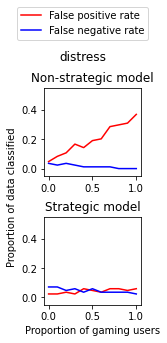

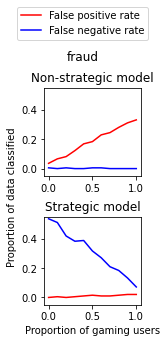

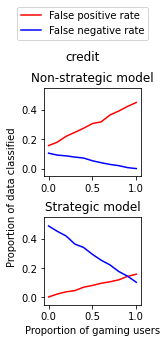

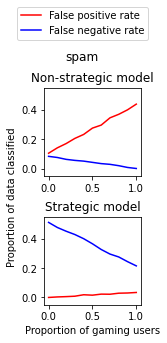

In [11]:
PATH = "./models/vanilla_quad"
results = []

for training_data in training_datas:
    path = PATH + "/" + training_data["name"]
    
    # load dataset
    X = training_data["X"]
    Y = training_data["Y"]
    Xval = training_data["Xval"]
    Yval = training_data["Yval"]
    Xtest = training_data["Xtest"]
    Ytest = training_data["Ytest"]
    
    # save dataset splits
    if not os.path.exists(path):
        os.makedirs(path)
    pd.DataFrame(X.numpy()).to_csv(path + '/X.csv')
    pd.DataFrame(Y.numpy()).to_csv(path + '/Y.csv')
    pd.DataFrame(Xval.numpy()).to_csv(path + '/Xval.csv')
    pd.DataFrame(Yval.numpy()).to_csv(path + '/Yval.csv')
    pd.DataFrame(Xtest.numpy()).to_csv(path + '/Xtest.csv')
    pd.DataFrame(Ytest.numpy()).to_csv(path + '/Ytest.csv')
    
    # training parameters
    x_dim = len(X[0])
    epochs = training_data["epochs"]
    batch_size = training_data["batch_size"]
    
    for cost in costs:
        funcs = {"f": f, "g": g, "f_derivative": f_derivative, "c": cost["cost_function"], "score": score}
        
        for scale in scales:
            path = PATH + "/" + training_data["name"] + "/" + cost["name"] + "/" + str(scale)
            print("------------------------- {}, {}, {} -------------------------".format(training_data["name"], cost["name"], scale))
            
            # load non-strategic and strategic model
            non_strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, scale=scale, strategic=False)
            non_strategic_model.load_model(path + "/non_strategic/model.pt")
            non_strategic_model.normalize_weights()
            
            strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, scale=scale, strategic=True)
            strategic_model.load_model(path + "/strategic/model.pt")
            
            #create strategically modified data
            X_opt_ns = non_strategic_model.optimize_X(Xtest, evaluation=True)
            X_opt_s = strategic_model.optimize_X(Xtest, evaluation=True)
            
            #proportion of gaming users
            betas = np.arange(0.0, 1.1, 0.1)
            
            #accuracies
            acc_nonstr=[]
            acc_str=[]
            #false positive and false negative error rates
            ns_FN = []
            ns_FP = []
            s_FN = []
            s_FP = []

            for beta in betas:
                 
                #create mixed strategic/nonstrategic data
                X_mixed_ns = torch.clone(Xtest)
                X_mixed_s = torch.clone(Xtest)
                n = len(Xtest)
                rand_incices = random.sample(range(n), int(n * beta))
                for i in rand_incices:    
                        X_mixed_ns[i] = X_opt_ns[i]
                        X_mixed_s[i] = X_opt_s[i]
                
                #get model predictions
                ns_pred = non_strategic_model.score(X_mixed_ns)
                nstrat_acc = non_strategic_model.calc_accuracy(Ytest, ns_pred)
                acc_nonstr.append(nstrat_acc)
            
                strat_pred = strategic_model.score(X_mixed_s)
                strat_acc = strategic_model.calc_accuracy(Ytest, strat_pred)
                acc_str.append(strat_acc)
                
                
                
                #save confusion matrix results
                ns_conf = conf_mat(Ytest, np.sign(ns_pred.detach().numpy()))[0]
                #normalize by number of samples
                n = np.sum(ns_conf)
                ns_FP.append(ns_conf[0][1]/n)
                ns_FN.append(ns_conf[1][0]/n)

                s_conf = conf_mat(Ytest, np.sign(strat_pred.detach().numpy()))[0]
                s_FP.append(s_conf[0][1]/n)
                s_FN.append(s_conf[1][0]/n)
                    

            results.append((acc_nonstr, acc_str, training_data['name']))
            
            #plotting of the false positive/negative rates
            fig, ax = plt.subplots(2)
            fig.set_size_inches(2, 4)
            ax[0].set_title("Non-strategic model")
            l1 = ax[0].plot(betas, ns_FP, 'r', label='False positives')
            l2 = ax[0].plot(betas, ns_FN, 'b', label='False negatives')
            ax[0].set_ylim([-0.05, 0.55])
            
            ax[1].set_title("Strategic model")
            l3 = ax[1].plot(betas, s_FP, 'r', label='False positives')
            l4 = ax[1].plot(betas, s_FN, 'b', label='False negatives')
            ax[1].set_ylim([-0.05, 0.55])
            
            fig.legend([l1, l2], labels=['False positive rate','False negative rate'], loc='lower center', 
                                               bbox_to_anchor=(0.5, 1)
                                              )
            fig.tight_layout()
            fig.suptitle(training_data["name"])
            plt.subplots_adjust(top=0.85)
            fig.add_subplot(111, frameon=False)
            plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
            plt.ylabel("Proportion of data classified")
            plt.xlabel("Proportion of gaming users")
            fig.show()

<ipython-input-12-98fc5a276fa7>:17: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2, l3], labels=['Non-strategic model','Strategic model', 'Benchmark'], loc='lower center',


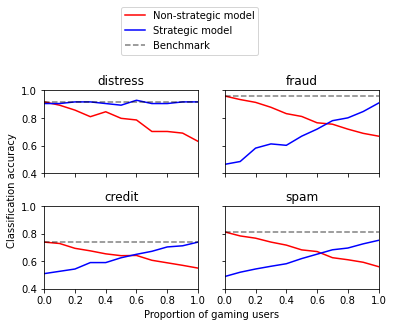

In [12]:
#plotting of the accuracies
fig, ax = plt.subplots(2, 2)

fig.add_subplot(111, frameon=False)
for idx, (acc_nonstr, acc_str, name) in enumerate(results):
    a = ax[idx//2, idx%2]
    a.set_title(name)
    l1 = a.plot(betas, acc_nonstr, 'r', label='Non-strategic model')
    l2 = a.plot(betas, acc_str, 'b', label='Strategic model')
    l3 = a.axhline(y = acc_nonstr[0], color = 'black', linestyle = '--', alpha=0.5)
    a.set_ylim([0.4, 1])
    a.set_xlim([0, 1])

for ax in fig.get_axes():
    ax.label_outer()

fig.legend([l1, l2, l3], labels=['Non-strategic model','Strategic model', 'Benchmark'], loc='lower center', 
           bbox_to_anchor=(0.5, 1)
          )


plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Classification accuracy")
plt.xlabel("Proportion of gaming users")
plt.tight_layout()